# Splitting the Smaller Posterior Files based on Velocity

From the previous Notebook, I figured out that it can actually be quite complicated because some of the components are actually quite broad in the velocity space so sometimes the red end of one component will overlap with the blue end of another, making it challenging to figure out where to set those velocity cutoffs for the bins. So what we are going to do instead is go through each of the smaller posterior files and make the velocity binnings off of that, where it should be easier to break things up because there should only be a few velocity components. This should also make it easier to sort out the purely noise components and also locate the more diffuse gas that is somehow evading the peak finder.

In [517]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io
from astropy.io import fits
import pandas as pd
import matplotlib as mpl
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u
import pickle
import math
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from tqdm import tqdm
from astropy.stats import sigma_clip

import os

%matplotlib inline
import matplotlib.pyplot as plt

In [380]:
path = 'B10_velocity_posterior.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header
print(header)

wcs_b10 = wcs.WCS(header)
print(wcs_b10)
print(data.shape)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  181                                                  NAXIS2  =                  181                                                  NAXIS3  =                  199                                                  WCSAXES =                    3 / Number of coordinate axes                      CRPIX1  =               -693.0 / Pixel coordinate of reference point            CRPIX2  =               9601.0 / Pixel coordinate of reference point            CRPIX3  =                  0.0 / Pixel coordinate of reference point            CDELT1  =      -0.001666666707 / [deg] Coordinate increment at reference point  CDELT2  =       0.001666666707 / [deg] Coordinate increment at reference point  CDELT3  =    0.020100486924401 / [km/s] 

6.200500883599904
Yes


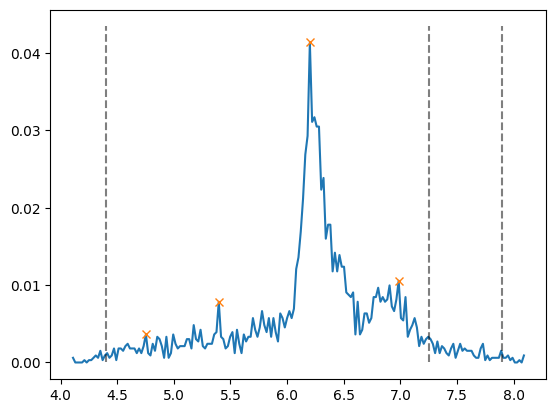

In [400]:
vel_start = header["CRVAL3"]
vel_inc = header["CDELT3"]

v_channels = np.arange(header["NAXIS3"])

#define velocity as km/s blocks
velocity = vel_start + (vel_inc * v_channels)
velocity = np.array(velocity, dtype = float)

posterior_dist = data[:, 129, 109]

peaks, _ = find_peaks(posterior_dist, height=np.nanmax(posterior_dist) * 0.05, 
                      distance = 20, 
                      prominence = np.nanmax(posterior_dist) * 0.05)#, 
                     #width = [1, 15])
heights = _['peak_heights']

#print(sorted(heights, reverse = True)[0])
print(velocity[list(posterior_dist).index(sorted(heights, reverse = True)[0])])
if velocity[list(posterior_dist).index(sorted(heights, reverse = True)[0])] < 7.0:
    print('Yes')
else:
    print('No')
#print(peaks)
#for i in range(len(peaks)):
    #print(velocity[list(posterior_dist).index(sorted(heights, reverse = True)[i])])

plt.figure()
plt.plot(velocity, posterior_dist)
plt.plot(velocity[peaks], posterior_dist[peaks], "x")
plt.vlines(4.4, np.min(posterior_dist), np.max(posterior_dist)*1.05, colors = 'black', linestyle = 'dashed', alpha = 0.5)
#plt.vlines(5.84, np.min(posterior_dist), np.max(posterior_dist)*1.05, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.vlines(7.25, np.min(posterior_dist), np.max(posterior_dist)*1.05, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.vlines(7.9, np.min(posterior_dist), np.max(posterior_dist)*1.05, colors = 'black', linestyle = 'dashed', alpha = 0.5)

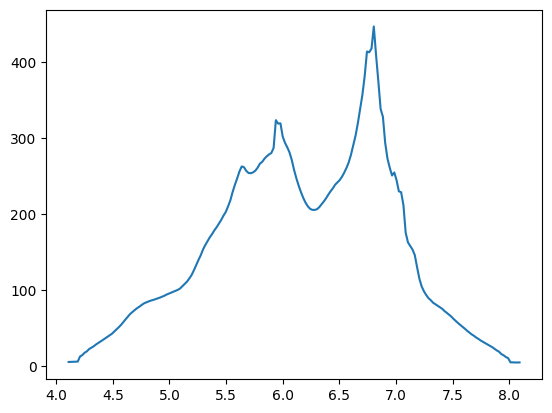

In [47]:
rng = range(len(velocity))
spectrum = []
for i in rng:
    spectrum += [np.nansum(data[i, :, :])]

plt.plot(velocity, spectrum)

In [221]:
peaks_grid_1 = []
peaks_grid_2 = []
#peaks_grid_3 = []
for i in tqdm(range(181)):
    row_number_1 = []
    row_number_2 = []
    #row_number_3 = []
    for j in range(181):
        posterior_dist = data[:, i, j]
        if math.isnan(np.sum(posterior_dist)):
            row_number_1.append(np.sum(posterior_dist))
            row_number_2.append(np.sum(posterior_dist))
            #row_number_3.append(np.sum(posterior_dist))
        else:
            peaks, _ = find_peaks(posterior_dist, height=np.nanmax(posterior_dist) * 0.05, 
                                  #height = 0.01,
                                  distance = 20, 
                                  prominence = np.nanmax(posterior_dist) * 0.05)
            heights = _['peak_heights']

            specific_heights = []
            for l in range(len(heights)):
                specific_heights.append(velocity[list(posterior_dist).index(sorted(heights, reverse = True)[l])])
            bin_1 = []
            bin_2 = []
            #bin_3 = []

            if 40 < j and 45 < i:
                for k in specific_heights:
                    if 4.5 < k < 7.25:
                        bin_1.append(k)
                    elif 7.25 < k < 7.4:
                        bin_2.append(k)
            else:
                for k in specific_heights:
                    if 4.5 < k < 6.84:
                        bin_1.append(k)
                    elif 6.84 < k < 7.4:
                        bin_2.append(k)
                    
            if len(bin_1) >= 1:
                row_number_1.append(bin_1[0])
            else:
                row_number_1.append(data[0, 4, 170])

            if len(bin_2) >= 1:
                row_number_2.append(bin_2[0])
            else:
                row_number_2.append(data[0, 4, 170])

            #if len(bin_3) >= 1:
                #row_number_3.append(bin_3[0])
            #else:
                #row_number_3.append(data[0, 4, 170])
            
    peaks_grid_1.append(row_number_1)
    peaks_grid_2.append(row_number_2)
    #peaks_grid_3.append(row_number_3)

100%|█████████████████████████████████████████| 181/181 [00:02<00:00, 87.33it/s]


6.039696988204696 0.6135520055836077


/tmp/ipykernel_161507/4247388454.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('bwr')
/tmp/ipykernel_161507/4247388454.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('bwr')


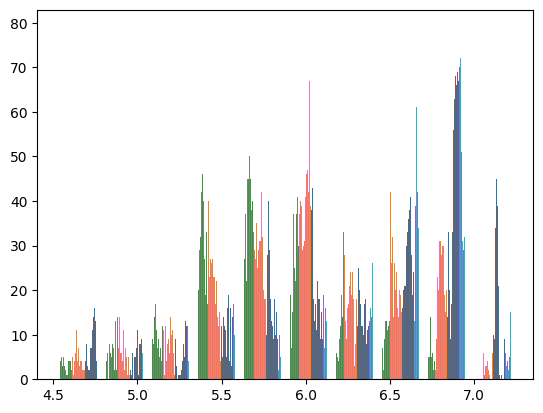

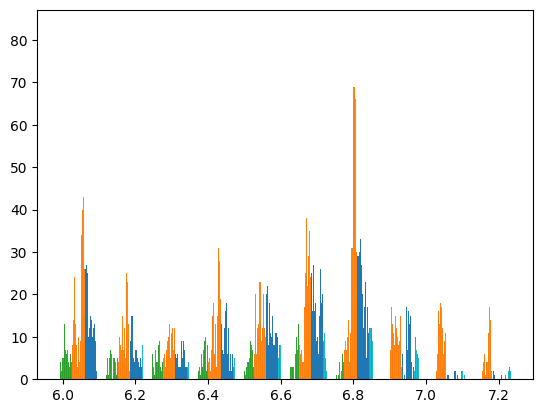

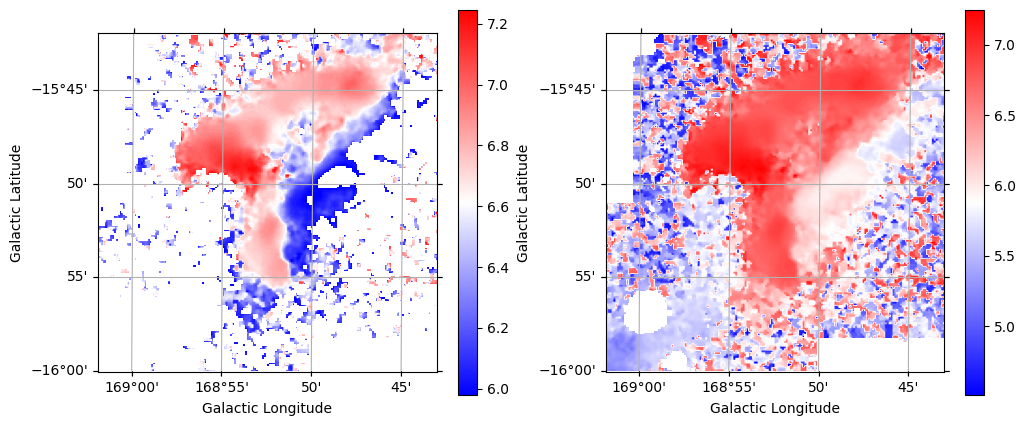

In [554]:
plt.hist(peaks_grid_1)
print(np.nanmedian(peaks_grid_1), np.nanstd(peaks_grid_1))

sigma_mask = sigma_clip(peaks_grid_1, sigma = 1.1, maxiters = None, cenfunc = 'mean', grow = 1.5)
newmask = (peaks_grid_1 < np.amax(sigma_mask))

peaks_grid_masked = np.ma.array(peaks_grid_1, mask = newmask)
plt.figure()
plt.hist(peaks_grid_masked)

plt.figure(figsize = [12, 5])

ax = plt.subplot(121, projection = wcs_b10, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('bwr')
im = ax.imshow(peaks_grid_masked, origin = 'lower', cmap = cm)
ax.grid(which = 'major')
plt.minorticks_on()
plt.colorbar(im)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

ax = plt.subplot(122, projection = wcs_b10, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('bwr')
im = ax.imshow(peaks_grid_1, origin = 'lower', cmap = cm)
ax.grid()
plt.minorticks_on()
plt.colorbar(im)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

output_hdu = wcs_b10.to_fits()
output_hdu[0].data is None

output_hdu[0].data = peaks_grid_1

output_hdu.writeto("B10_velocity_grid_blue.fits", overwrite=True)

output_hdu = wcs_b10.to_fits()
output_hdu[0].data is None

output_hdu[0].data = peaks_grid_2

output_hdu.writeto("B10_velocity_grid_red.fits", overwrite=True)

In [291]:
path = 'B10_velocity_grid_blue.fits'
cube = fits.open(path)
blue_data = cube[0].data
header = cube[0].header
#print(header)

wcs_blue = wcs.WCS(header)

print(wcs_blue)
print(blue_data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL' 'GLAT-SFL' 'v' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(4.1100502434622) 
CRPIX : np.float64(-693.0) np.float64(9601.0) np.float64(0.0) 
PC1_1 PC1_2 PC1_3  : np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3  : np.float64(0.0) np.float64(1.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3  : np.float64(0.0) np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(-0.001666666707) np.float64(0.001666666707) np.float64(0.020100486924401) 
NAXIS : 181  181
(181, 181)


In [290]:
path = 'distance_transform.fits'
cube = fits.open(path)
distance_transform_data = cube[0].data
header = cube[0].header
#print(header)

wcs_dist_transform = wcs.WCS(header)

print(wcs_dist_transform)
print(distance_transform_data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL' 'GLAT-SFL' 'v' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(4.1100502434622) 
CRPIX : np.float64(1100.0) np.float64(9785.0) np.float64(0.0) 
PC1_1 PC1_2 PC1_3  : np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3  : np.float64(0.0) np.float64(1.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3  : np.float64(0.0) np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(-0.001666666707) np.float64(0.001666666707) np.float64(0.020100486924401) 
NAXIS : 2200  800
(800, 2200)


In [351]:
list_ = open("Seo_NH3_peaks.txt").read().split()
strings = list_[4:]
ra_strings = []
dec_strings = []
for i in range(39):
    ra_strings.append(strings[i*3])
    dec_strings.append(strings[i*3+1])

print(ra_strings)

ra = []
dec = []
for i in range(39):
    ra_val = ra_strings[i]
    ra_value = float(ra_val[0])*15 + 15*float(ra_val[2:4])/60 + 15*float(ra_val[5:11])/3600
    ra.append(ra_value)

    dec_val = dec_strings[i]
    dec_value = float(dec_val[0:2]) + float(dec_val[3:5])/60 + float(dec_val[6:11])/3600
    dec.append(dec_value)

c = SkyCoord(ra, dec, frame='icrs', unit='deg')
galactic_coords = c.galactic

lat = np.array(galactic_coords.l*u.degree)
lon = np.array(galactic_coords.b*u.degree)

print(lat, lon)

c = SkyCoord(lat, lon, frame='galactic', unit='deg')

pixels_x, pixels_y = astropy.wcs.utils.skycoord_to_pixel(c, wcs = wcs_dist_transform, origin=1)
pixels_x_vel, pixels_y_vel = astropy.wcs.utils.skycoord_to_pixel(c, wcs = wcs_b10, origin=1)

['4:18:32.971,', '4:18:33.187,', '4:18:39.139,', '4:18:45.919,', '4:18:04.195,', '4:17:52.834,', '4:18:02.557,', '4:18:03.746,', '4:18:07.007,', '4:17:37.638,', '4:17:51.159,', '4:17:41.727,', '4:17:42.205,', '4:17:42.980,', '4:17:41.086,', '4:17:36.147,', '4:17:50.322,', '4:18:11.654,', '4:18:10.957,', '4:18:07.877,', '4:19:23.312,', '4:19:37.101,', '4:19:42.538,', '4:19:51.462,', '4:19:57.644,', '4:20:09.655,', '4:20:14.724,', '4:20:12.236,', '4:20:15.462,', '4:21:02.518,', '4:20:51.604,', '4:20:54.058,', '4:21:21.694,', '4:21:12.452,', '4:24:20.598,', '4:24:25.285,', '4:27:47.490,', '4:27:55.776,', '4:28:09.213,']
[168.70634248 168.71664767 168.77873061 168.79614677 168.69495341
 168.7960094  168.84623051 168.88931351 168.92384215 168.76103748
 168.7667017  168.81281518 168.8300372  168.85073101 168.87303686
 168.8711489  168.99737072 169.30686993 169.31031443 169.32061943
 169.76131449 169.79092674 169.8290636  169.87764782 169.90889742
 169.94709284 169.98698022 170.00084228 170.0

/tmp/ipykernel_161507/982812520.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('magma_r')


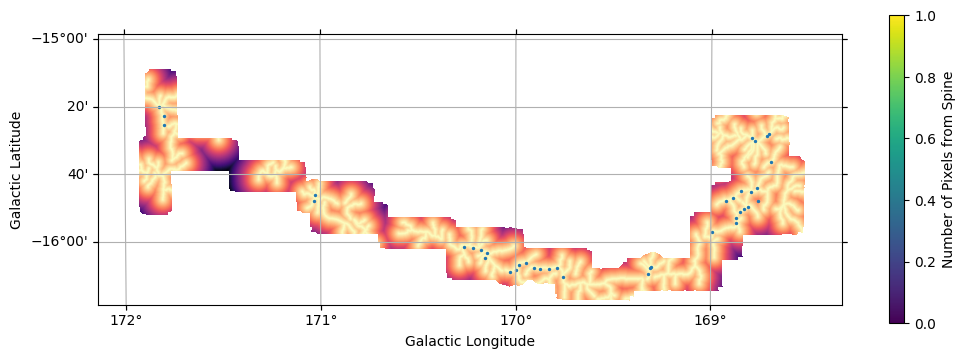

In [561]:
plt.figure(figsize = [12,4])
ax = plt.subplot(projection=wcs_dist_transform, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('magma_r')
plt.imshow(distance_transform_data, origin = 'lower', cmap = cm)
plt.scatter(pixels_x, pixels_y, s = 2)
plt.colorbar(label = 'Number of Pixels from Spine')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.grid()

169.03005362073569 168.7184959477109
-16.0000003872 -15.698333713233
1793 1974
184 365
6.200500883599904
92.01048548895983 70.00103803981256


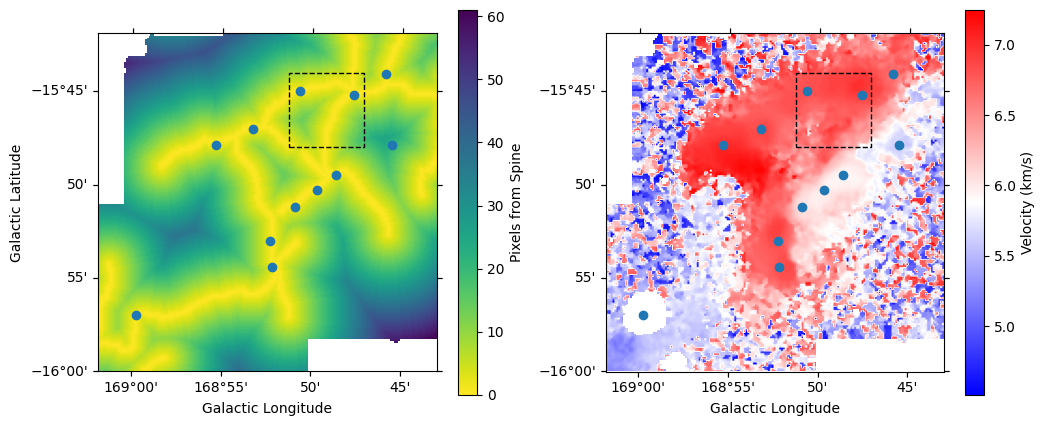

In [570]:
(l_min, b_min, vel), (l_max, b_max, vel) = wcs_b10.wcs_pix2world([[0, 0, 0], [181, 181, 0]], 0)

print(l_min, l_max)
print(b_min, b_max)

(l_min, b_min, vel), (l_max, b_max, vel) = wcs_dist_transform.wcs_world2pix([[l_min, b_min, 0], [l_max, b_max, 0]], 0)

print(round(l_min), round(l_max))
print(round(b_min), round(b_max))

print(peaks_grid_1[129][109])

subregion = distance_transform_data[round(b_min):round(b_max), round(l_min):round(l_max)]

plt.figure(figsize = [12, 5])
ax_1 = plt.subplot(122, projection = wcs_b10, slices=('x', 'y', 0))
im = ax_1.imshow(peaks_grid_1, cmap = 'bwr')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_1.set(xlim=(0, 181), ylim=(0, 181))
cbar = plt.colorbar(im, label = 'Velocity (km/s)')
ax_1.add_patch(plt.Rectangle((102, 120), 40, 40, ls="--", ec="k", fc="none"))
#ax_1.add_patch(plt.Circle((109, 129), 1))
ax_1.scatter(pixels_x_vel, pixels_y_vel)


ax_2 = plt.subplot(121, projection = wcs_dist_transform, slices=('x', 'y', 0))
im = ax_2.imshow(distance_transform_data, cmap = 'viridis_r', vmax = np.nanmax(subregion))
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
ax_2.set(xlim=(l_min, l_max), ylim=(b_min, b_max))
cbar = plt.colorbar(im, label = 'Pixels from Spine')
ax_2.add_patch(plt.Rectangle((l_min + 102, b_min + 120), 40, 40, ls="--", ec="k", fc="none"))

ax_2.scatter(pixels_x, pixels_y)

print(pixels_x_vel[14], pixels_y_vel[14])

40 40
40 40
40 40
40 40
40
0.3595684411504506


/tmp/ipykernel_161507/539183771.py:32: RuntimeWarning: invalid value encountered in scalar divide
  proj_length = (-grad_x_spines[i][j] * grad_x_vel[i][j] + -grad_y_spines[i][j] * grad_y_vel[i][j])/((grad_x_spines[i][j])**2 + (grad_y_spines[i][j])**2)


[(0.0, 39.5), (0.0, 39.5)]

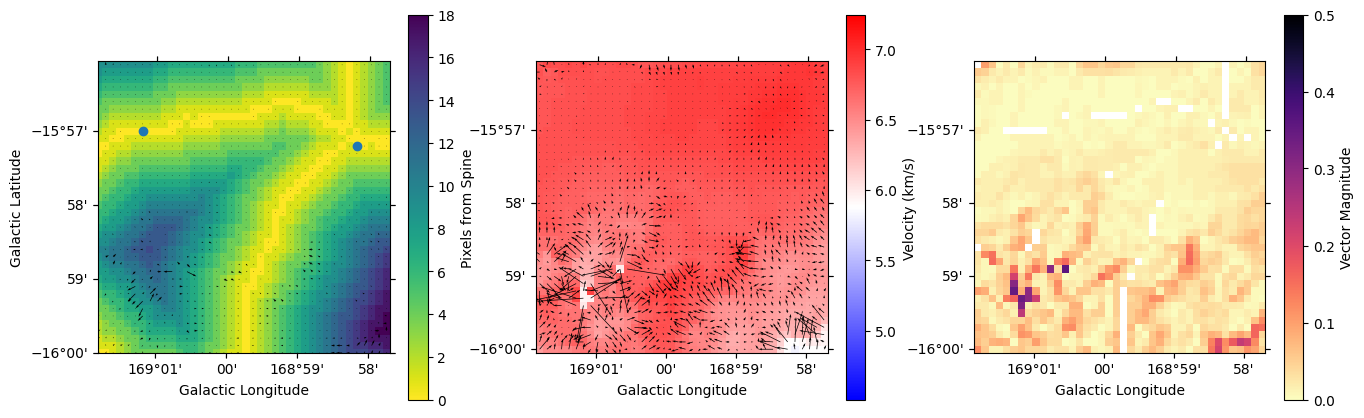

In [571]:
def divergence(scalar_field):
    gy, gx = np.gradient(scalar_field)
    print(len(gx[0]), len(gy[0]))
    return(gy, gx)

lon_length, lat_length = 40, 40
lon_start, lat_start = 102, 120

subregion_vel = blue_data[lat_start:lat_start + lat_length, lon_start:lon_start + lon_length]
grad_y_vel, grad_x_vel = divergence(subregion_vel) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_vel), len(grad_y_vel))

subregion_spines = distance_transform_data[round(b_min + lat_start):round(b_min + lat_start + lat_length), round(l_min + lon_start):round(l_min + lon_start + lon_length)]
grad_y_spines, grad_x_spines = divergence(subregion_spines) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_spines), len(grad_y_spines))

x = np.arange(0, lon_length, 1)
y = np.arange(0, lat_length, 1)

X, Y = np.meshgrid(x,y)

print(len(y))

perp_grad_x = []
perp_grad_y = []
divergence = []
for i in range(len(y)):
    x_values = []
    y_values = []
    summed = []
    for j in range(len(x)):
        proj_length = (-grad_x_spines[i][j] * grad_x_vel[i][j] + -grad_y_spines[i][j] * grad_y_vel[i][j])/((grad_x_spines[i][j])**2 + (grad_y_spines[i][j])**2)
        x_values.append(-grad_x_spines[i][j] * proj_length)
        y_values.append(-grad_y_spines[i][j] * proj_length)
        summed.append(np.sqrt((-grad_x_spines[i][j] * proj_length)**2 + (-grad_y_spines[i][j] * proj_length)**2))
    perp_grad_x.append(x_values)
    perp_grad_y.append(y_values)
    divergence.append(summed)

print(np.nanmax(divergence))

plt.figure(figsize = [16, 5])

ax_3 = plt.subplot(133, projection = wcs_blue, slices=('x', 'y', 0))
im = ax_3.imshow(divergence, cmap = 'magma_r', vmax = 0.5)
#im = ax_1.imshow(perp_divergence, cmap = 'magma')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
#plt.quiver(x, y, grad_x_vel, grad_y_vel, color = 'black')
cbar = plt.colorbar(im, label = 'Vector Magnitude')

ax_1 = plt.subplot(132, projection = wcs_blue, slices=('x', 'y', 0))
im = ax_1.imshow(subregion_vel, cmap = 'bwr', vmin = np.nanmin(blue_data), vmax = np.nanmax(blue_data))
#im = ax_1.imshow(perp_divergence, cmap = 'magma')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
plt.quiver(x, y, grad_x_vel, grad_y_vel, color = 'black')
cbar = plt.colorbar(im, label = 'Velocity (km/s)')

ax_1 = plt.subplot(131, projection = wcs_blue, slices=('x', 'y', 0))
im = ax_1.imshow(subregion_spines, cmap = 'viridis_r', vmax = np.nanmax(subregion_spines))
plt.quiver(x, y, perp_grad_x, perp_grad_y, color = 'black', scale = 10)
#plt.quiver(x, y, -grad_x_spines, -grad_y_spines, color = 'black')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
cbar = plt.colorbar(im, label = 'Pixels from Spine')
#ax_1.add_patch(plt.Circle((109, 129), 1))
ax_1.scatter(pixels_x_vel-102, pixels_y_vel-120)
ax_1.set(xlim=(0,39.5), ylim=(0, 39.5))